Martín Amado - 19020
Juan Pablo Pineda - 19087

Referencia para análisis de datos: https://www.kaggle.com/competitions/digit-recognizer/data?select=test.csv

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from scipy import stats
import matplotlib.cm as cm
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from apyori import apriori

# Ejercicio 1

# Ejercicio 2

## Parte 1: Series de tiempo

### Consumos Diesel

Recaudacion y limpieza de datos

In [51]:
consumption = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
consumption = consumption[['Fecha', 'Diesel']]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumption = consumption[:269]

Desarrollo de la seria de tiempo

In [52]:
trainSize = int(len(consumption) * 0.7)
trainConsumos = consumption[0:trainSize]
testConsumos = consumption[trainSize:len(consumption)]
trainConsumos = trainConsumos.set_index(['Fecha'])
testConsumos = testConsumos.set_index(['Fecha'])

In [53]:
tsDiesel = trainConsumos['Diesel']
mediaMovil = tsDiesel.rolling(window=12).mean()
deMovil = tsDiesel.rolling(window=12).std()

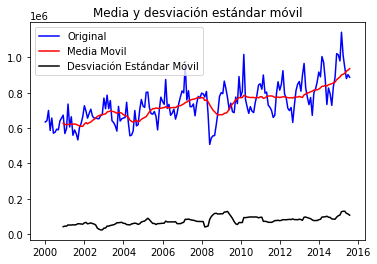

In [54]:
original = plt.plot(tsDiesel, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

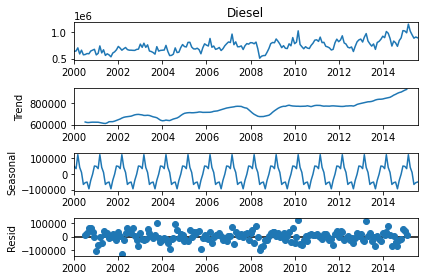

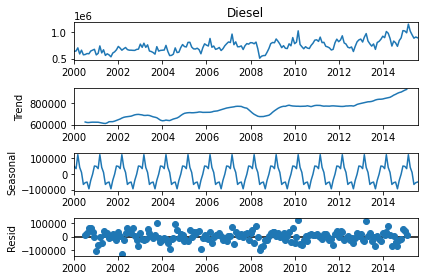

In [55]:
descomposicion = seasonal_decompose(tsDiesel)
descomposicion.plot()

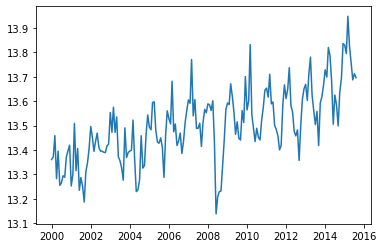

In [56]:
tsDiesel = tsDiesel.astype({'Diesel':'float'})
tsDieselLog = np.log(tsDiesel)
plt.plot(tsDieselLog)

In [57]:
dfTest = adfuller(tsDiesel, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Valor Crítico (%s)'%key] = value
print(salidaDf)

Estadístico de prueba         -0.141801
p-value                        0.945112
# de retardos usados          12.000000
# de observaciones usadas    175.000000
Valor Crítico (1%)            -3.468280
Valor Crítico (5%)            -2.878202
Valor Crítico (10%)           -2.575653
dtype: float64


In [58]:
tsDieselDiff = tsDiesel.diff()
tsDieselDiff.fillna(0,inplace=True)
dfTest = adfuller(tsDieselDiff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Estadístico de prueba         -5.546664
p-value                        0.000002
# de retardos usados          11.000000
# de observaciones usadas    176.000000
Critical Value (1%)           -3.468062
Critical Value (5%)           -2.878106
Critical Value (10%)          -2.575602
dtype: float64

Text(0.5, 1.0, 'Diferenciacion de la serie')

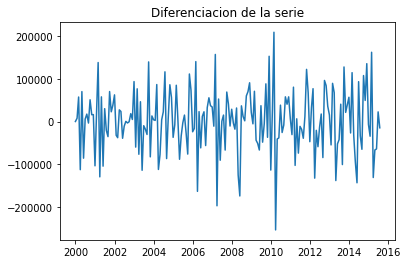

In [59]:
plt.plot(tsDieselDiff)
plt.title('Diferenciacion de la serie')

In [60]:
modelo111 = SARIMAX(tsDieselLog, order=(1,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
resultado_m111.summary().tables[1]

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.0315,0.162,0.194,0.846,-0.286,0.349
ma.L1,-0.6126,0.119,-5.152,0.000,-0.846,-0.380
ar.S.L12,-0.7276,0.087,-8.382,0.000,-0.898,-0.557
ar.S.L24,-0.5636,0.103,-5.480,0.000,-0.765,-0.362
ar.S.L36,-0.3038,0.086,-3.527,0.000,-0.473,-0.135
sigma2,0.0048,0.000,11.515,0.000,0.004,0.006


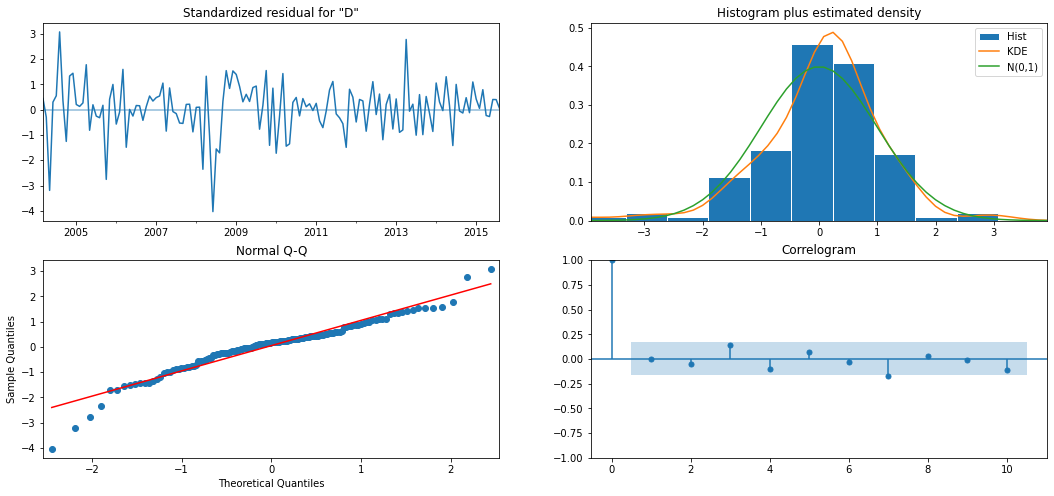

In [61]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

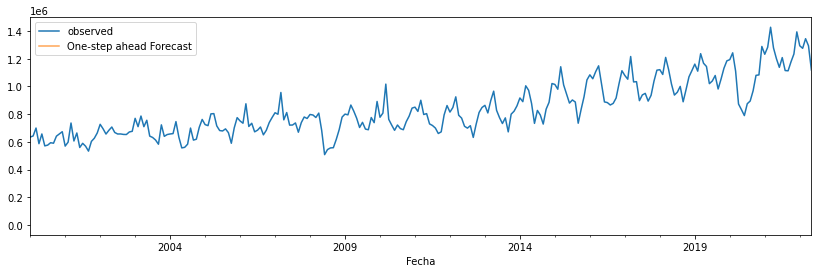

In [62]:
testConsumos.index[0]
pred = resultado_m111.get_prediction(start=testConsumos.index[0], dynamic=False)
pred_ci = pred.conf_int()
consumoIndexed = consumption.set_index('Fecha')
consumoIndexed = consumoIndexed['Diesel']
ax = consumoIndexed['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

## Parte 2: LSTM

In [71]:
consumo = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
consumo = consumo[['Fecha', 'Diesel']]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumo = consumo[:269]
consumo = consumo.set_index('Fecha')
consumo.head()

,Diesel
Fecha,
2000-01-01,634667.06
2000-02-01,642380.66
2000-03-01,699807.25
2000-04-01,586803.98
2000-05-01,656948.2


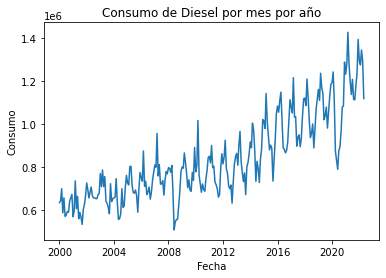

In [73]:
plt.plot(consumo)
plt.gca().set(title="Consumo de Diesel por mes por año", xlabel="Fecha", ylabel="Consumo")
plt.show()

Estacionarizar para uso de LSTM

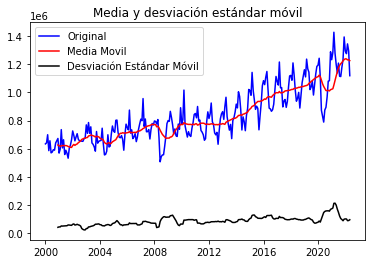

In [74]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = consumo.rolling(window=12).mean()
deMovil = consumo.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(consumo, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

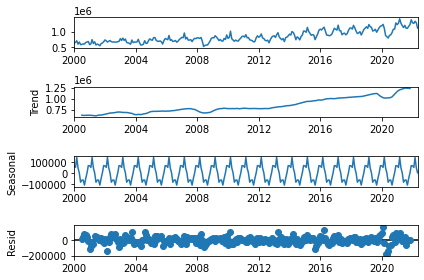

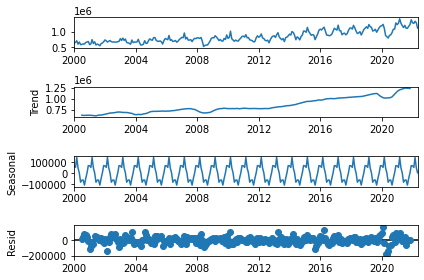

In [75]:
descomposicion = seasonal_decompose(consumo)
descomposicion.plot()

Existe tendencia

In [76]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumo, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.046948
p-value                        0.954473
# de retardos usados          12.000000
# de observaciones usadas    256.000000
Critical Value (1%)           -3.456155
Critical Value (5%)           -2.872897
Critical Value (10%)          -2.572822
dtype: float64


In [77]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
diesel_diff = consumo.diff()
diesel_diff.fillna(0,inplace=True)
dfTest = adfuller(diesel_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -6.528469e+00
p-value                      1.000760e-08
# de retardos usados         1.100000e+01
# de observaciones usadas    2.570000e+02
Critical Value (1%)         -3.456054e+00
Critical Value (5%)         -2.872853e+00
Critical Value (10%)        -2.572799e+00
dtype: float64


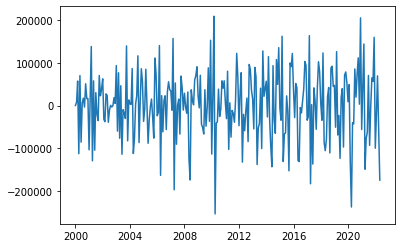

In [78]:
plt.plot(diesel_diff)

Necesidad de diferenciacion

In [80]:
scaler = StandardScaler()
diesel_scaled = scaler.fit_transform(diesel_diff) 
diesel_scaled[1:7]

array([[ 0.07505497],
       [ 0.70616145],
       [-1.45744589],
       [ 0.86761179],
       [-1.11499886],
       [ 0.04715821]])

60% entrenamiento, 20% validacion y prueba

In [90]:
train_diesel = round(0.6*len(diesel_scaled))
val_test_diesel = round(0.2*len(diesel_scaled))
test = diesel_scaled[(train_diesel + val_test_diesel) - 1:]
validation = diesel_scaled[(train_diesel):train_diesel + val_test_diesel + 1]
train = diesel_scaled[0:train_diesel]
train = np.insert(train, 0, 0)
train = np.reshape(train, (train.shape[0], 1))

Transformacion a serie supervisada

In [91]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

#### Creacion de modelo

##### Modelo 1

Matrices de 3 dimensiones

In [93]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))

Modelo con una capa LSTM

In [99]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1)                    12        
                                                                 
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [100]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Entrenamiento

In [101]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
161/161 [==============================] - 2s 5ms/step - loss: 0.7893 - val_loss: 1.2304
Epoch 2/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7853 - val_loss: 1.2311
Epoch 3/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7817 - val_loss: 1.2322
Epoch 4/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7782 - val_loss: 1.2336
Epoch 5/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7748 - val_loss: 1.2352
Epoch 6/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7716 - val_loss: 1.2372
Epoch 7/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7684 - val_loss: 1.2393
Epoch 8/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7653 - val_loss: 1.2417
Epoch 9/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7622 - val_loss: 1.2442
Epoch 10/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7592 - val_loss: 1.2470

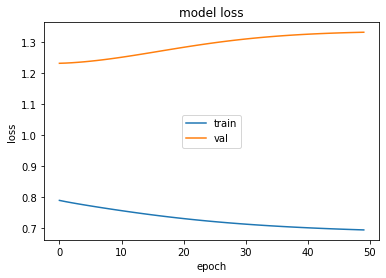

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [103]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 [==============================] - 0s 2ms/step - loss: 0.8476
Pérdida en Validación
2/2 [==============================] - 0s 2ms/step - loss: 1.2381
Pérdida en Prueba
2/2 [==============================] - 0s 3ms/step - loss: 1.6567


1.6566778421401978

Prediccion modelo 1

In [108]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel+val_test_diesel)


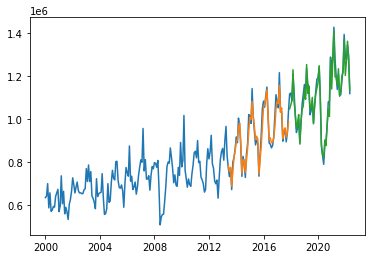

In [109]:
df_val = pd.DataFrame(prediccion_val,index=consumo[(train_diesel):train_diesel+val_test_diesel].index)
df_test = pd.DataFrame(prediccion_test,index=consumo[train_diesel+len(df_val):len(consumo)].index)


plt.plot(consumo)
plt.plot(df_val)
plt.plot(df_test)

##### Modelo 2

In [135]:
modelo2 = Sequential()
lote = 1
unidades =  5
paso = 1
caracteristicas = 1 #es univariada
modelo2.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (1, 1)                    12        
                                                                 
 dense_7 (Dense)             (1, 1)                    2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [136]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [137]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
161/161 [==============================] - 2s 5ms/step - loss: 0.8717 - val_loss: 1.2424
Epoch 2/50
161/161 [==============================] - 0s 2ms/step - loss: 0.8504 - val_loss: 1.2275
Epoch 3/50
161/161 [==============================] - 0s 2ms/step - loss: 0.8376 - val_loss: 1.2171
Epoch 4/50
161/161 [==============================] - 0s 2ms/step - loss: 0.8269 - val_loss: 1.2082
Epoch 5/50
161/161 [==============================] - 0s 2ms/step - loss: 0.8168 - val_loss: 1.2008
Epoch 6/50
161/161 [==============================] - 0s 2ms/step - loss: 0.8067 - val_loss: 1.1944
Epoch 7/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7967 - val_loss: 1.1890
Epoch 8/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7866 - val_loss: 1.1846
Epoch 9/50
161/161 [==============================] - 0s 3ms/step - loss: 0.7767 - val_loss: 1.1813
Epoch 10/50
161/161 [==============================] - 0s 2ms/step - loss: 0.7671 - val_loss: 1.1789

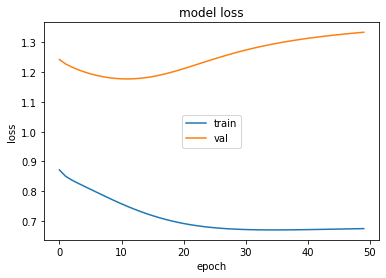

In [138]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [139]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 [==============================] - 0s 2ms/step - loss: 0.8434
Pérdida en Validación
2/2 [==============================] - 0s 3ms/step - loss: 1.2445
Pérdida en Prueba
2/2 [==============================] - 0s 2ms/step - loss: 1.6244


1.624419093132019

In [140]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo.values , n=train_diesel+val_test_diesel)


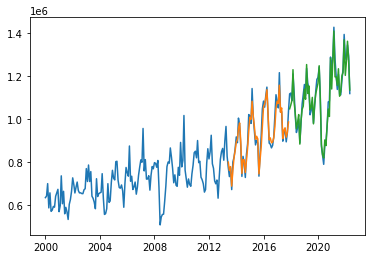

In [141]:
df_val = pd.DataFrame(prediccion_val,index=consumo[(train_diesel):train_diesel+val_test_diesel].index)
df_test = pd.DataFrame(prediccion_test,index=consumo[train_diesel+len(df_val):len(consumo)].index)


plt.plot(consumo)
plt.plot(df_val)
plt.plot(df_test)

